## Stokes Flow in Periodic Channel with Robin boundary.

In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"#"last_expr_or_assign"

import numpy as np
import matplotlib.pyplot as plt
from util.logger import EventTracker
from util.basis_scaled import *
from util.plot_tools import *
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from hmm.stokes import *

pretty_pyplot_layout()

## Multiscale Problem

We define a multiscale problem as follows. The PDE is a non-slip zero forcing Stokes flow Problem

\begin{equation}
\Delta u  - \nabla p = 0, \qquad \qquad \nabla \cdot u = 0   \qquad \text{inside}\quad \Omega
\end{equation}

with the boundary conditions

\begin{equation}
u = g,\qquad \text{on}\quad\partial\Omega
\end{equation}

the boundary is a two-dimensional pipe with corners at (0,-1) and (1,1), and a micro scale boundary:

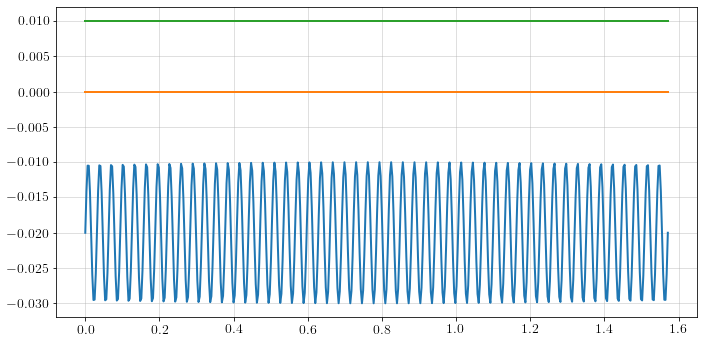

In [3]:

eps = 0.01
eval_pos = 1. * eps
dom = [[-1., 1.], [0., 0.5]]
Lx = dom[0][1] - dom[0][0]

nper = round(Lx/eps)
bbox = [dom[0], [dom[1][0]-eps, dom[1][1]]]
amp = 1.0
freq_g = 3
k = nper
k2 = 20
#print(k, k2)



def random_boundary(n, eps):
    m_vec = np.random.uniform(0.1*np.pi, 0.4*np.pi, n)
    a_vec = np.random.uniform(0, 1, n)
    a_vec = a_vec * eps
    
    scale = eps
    p = lambda x, m: np.exp(-np.abs(x-m)**2 / (2*scale**2))
    dp = lambda x, m: -2*(x-m)*p(x, m) / (2*scale**2)
    ddp = lambda x, m: (4*(x-m)**2/ (2*scale**2)**2 - 2 / (2*scale**2))*p(x, m) 
    
    f = lambda x: -sum([p(x, m)*a for m,a in zip(m_vec, a_vec)])-eps
    df = lambda x: -sum([dp(x, m)*a for m,a in zip(m_vec, a_vec)])
    ddf = lambda x: -sum([ddp(x, m)*a for m,a in zip(m_vec, a_vec)])
    return f, df, ddf


# Fnctions
A = 0#0.6
f = lambda x: eps * (1 + A*np.sin(k2 * x)) * (-1 + np.sin(k*x))-eval_pos #1.6
df = lambda x: eps * k * np.cos(k*x) * (1 + A * np.sin(k2 * x)) + eps * A * k2 * np.cos(k2 * x) * (-1 + np.sin(k*x))
ddf = lambda x: -eps * (k**2) * np.sin(k*x) * (1+ A * np.sin(k2 * x)) + 2 * eps * A * k2 * k * np.cos(k2 * x) * np.cos(k*x)\
                -eps * (k2**2) * A * np.sin(k2*x) * (-1 + np.sin(k*x))
                
#f, df, ddf = random_boundary(50, eps)
                
g = lambda x: np.exp(1 + (np.sin(2*np.pi * x / Lx)*0.4 + np.sin(freq_g*2*np.pi * x / Lx)*0.6)) * amp#*np.ones_like(x)

data = StokesData(f, df, ddf, g, dom, dom[0][1]-dom[0][0], dom[1][1]-dom[1][0])

x = np.linspace(0, 0.5*np.pi, 500)
plt.plot(x, f(x))
plt.plot(x, x*0.)
plt.plot(x, eval_pos + x*0.)


## Coupling to Micro Domain

To couple the macro domain to the microscopic domain, we make use of the HMM framework.
We construct a set of evenly spaced micro problems based on the Stokes data. The macro problem is constructed with a pre-specified resolution in the x- and y-directions.

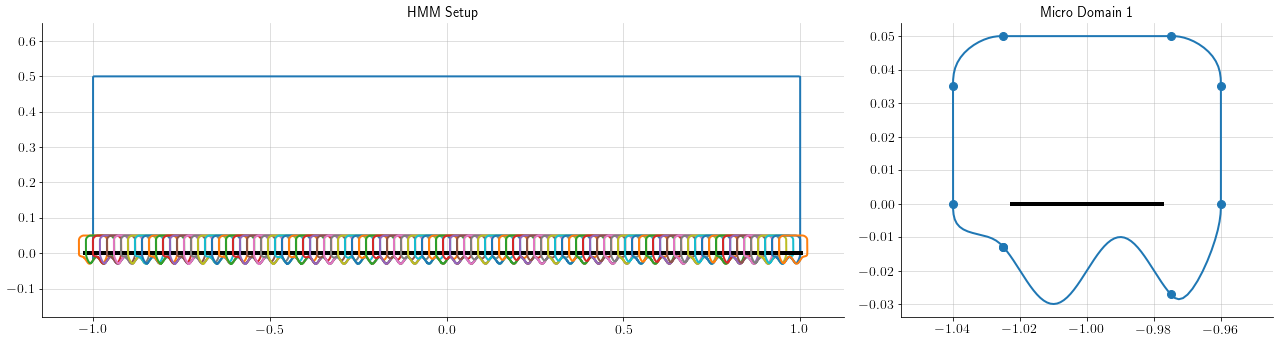

In [4]:
logger = EventTracker() # Log time

tol = 1e-4
#################
# Macro problem
#################

xDim = 301
yDim = 301
macro = StokesMacProb(data, lambda x,a: fft_interp(x, a, dom=dom[0]))
macro_0 = StokesMacProb(data, lambda x,a: fft_interp(x, a, dom=dom[0])) # For comparison
###################
# Micro problems
###################

nMic = 101 #freq_g*2+1#2*(round(Lx/(30*eps)) // 2) + 1 # 15 # 15 #nMic*2 +1
yDim_reduce=17
xDim_reduce=17
width=5*eps #3
height=width #3
n_refine=0
#xPos = np.linspace(dom[0][0]+4*eps, dom[0][1]-4*eps, nMic)-2*eps
xPos = np.linspace(dom[0][0], dom[0][1], nMic+1)[1:] - width/2 - Lx / nMic/1
micros = [StokesMicProb(data, x, width, height, 0.0, deg_project=8, logger=logger, 
                        n_refine=n_refine, xDim_reduce=xDim_reduce, yDim_reduce=yDim_reduce) for x in xPos]

###################
# Hmm problem.
conv_checker = ConvergenceChecker(macro, micros, tol=tol)
hmm_prob = StokesHMMProblem(macro, micros, data, convergence_checker=conv_checker)

###################
## PLOT ##
plt.figure(figsize=(18,5))


plt.subplot2grid((1, 3), (0, 0), 1, 2)
plt.title("HMM Setup")
hmm_prob.plot(plt.gca())
#data.plot(plt.gca())
plt.axis("Equal")
remove_top_right_axes(plt.gca())

plt.subplot2grid((1, 3), (0, 2), 1, 1)
plt.title("Micro Domain 1")
micros[0].plot(plt.gca(), showsegments=True)
plt.axis("Equal")
remove_top_right_axes(plt.gca())


## Solving using HMM iterations

To solve the problem, we make use of a sequence of micro solvers, as well as a micro solver.

In [5]:
class Callback():
    def __init__(self, macro):
        self.N = 100
        self.x = np.linspace(0,1,self.N)
        self.macro = macro
        self.current_alpha = macro.alpha(self.x)
        self.diff = []
    
    def __call__(self, it, macro_sol, micro_sols):
        self.previous_alpha = self.current_alpha
        self.current_alpha = self.macro.alpha(self.x)
        self.diff.append(np.linalg.norm(self.previous_alpha - self.current_alpha) / self.N**0.5)
        
debug_cb = Callback(macro)

print("Precomputing...")
macro_solver = MacroSolver(xDim, yDim, tol=tol, logger=logger)
micro_solvers = [MicroSolver(m, logger=logger, tol=tol) for m in micros]
hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)
print("Done")


print("HMM Solver...")
macro_guess = macro_solver.solve(macro)
(macro_sol, micro_sols) = hmm_solver.solve(hmm_prob, macro_guess=macro_guess, 
                                           callback=debug_cb, verbose=True, maxiter=10, tol=tol, logger=logger)
print("\nDone")

Precomputing...
Done
HMM Solver...
Convergence (not necessarily to solution) at step 5/10

Done


### Convergence and computation time

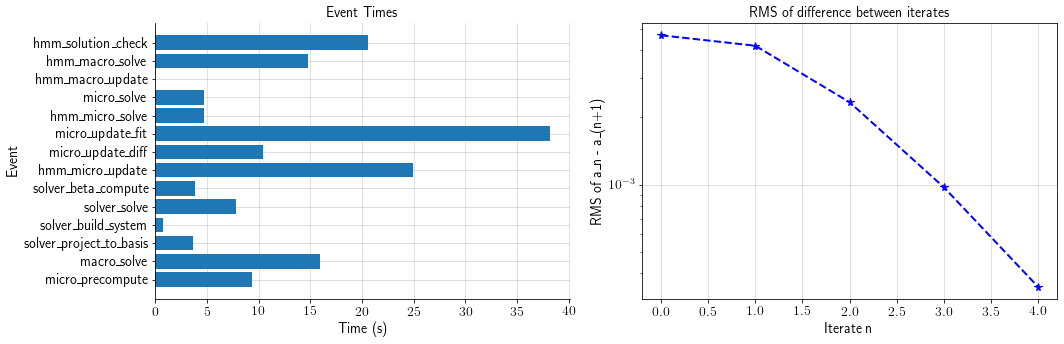

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(122)
plt.title("RMS of difference between iterates")
plt.semilogy(debug_cb.diff, 'b*--')
plt.xlabel("Iterate n")
plt.ylabel("RMS of a_n - a_(n+1)")

plt.subplot(121)
logger.barplot_logs(plt.gca())



## Accuracy
We use the reference solver data to construct a piecewise linear interpolation. Also, the micro data is used to construct a set of full solutions to the velocity field in the micro problems for visualisation purposes.

/tmp/ipykernel_29050/4147533264.py:4: RuntimeWarning: invalid value encountered in true_divide
  return np.where(np.abs(omega)<1e-3, np.ones_like(omega), np.sin(omega * a) / (omega * a))


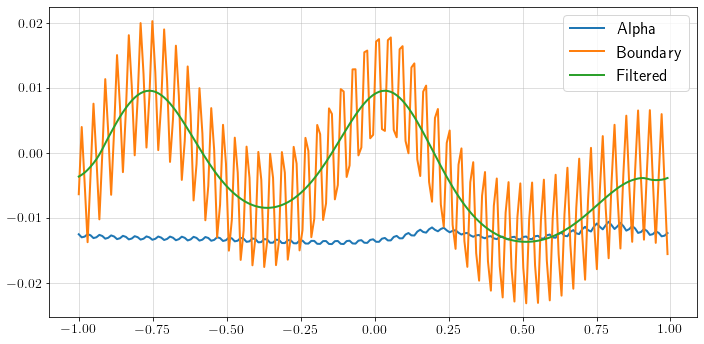

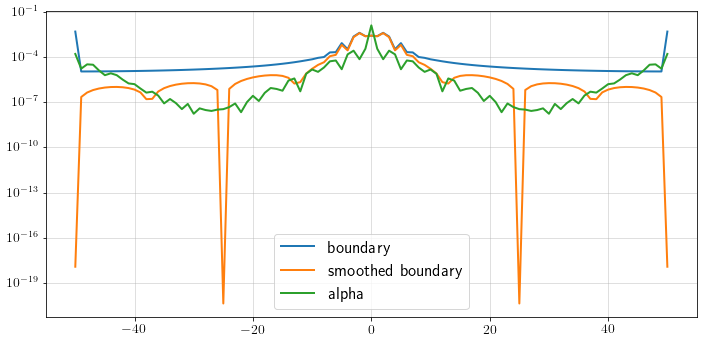

In [7]:
npts = 201

def sq_filt(omega, a):
    return np.where(np.abs(omega)<1e-3, np.ones_like(omega), np.sin(omega * a) / (omega * a))

# apply square filter convolution in the fourier domain
def square_filter(basis: FourBasis, filter_width: float):
    dim = basis.dim
    freq = FourBasis._freq(dim)/(2 * np.pi * 1j)
    coef = basis.coef * sq_filt(2 * np.pi * freq, filter_width)
    return FourBasis(coef)

gamma = eps*0.5
mix = lambda x: f(x)*(1-gamma) + g(x)*gamma
func = lambda x: mix(0.5*np.pi*(x - dom[0][0])/(dom[0][1] - dom[0][0]))
func_basis = ScaleShiftedBasis.fromFunctionInDomain(func, dom[0], basis=FourBasis, dim=macro.alpha.basis.dim)
filt_basis = square_filter(func_basis.basis, width * 0.8)
filt_basis = ScaleShiftedBasis(filt_basis, func_basis.scale, func_basis.shift)

macro.alpha.plot(plt.gca(), npts, label="Alpha")
func_basis.plot(plt.gca(), npts, label="Boundary")
filt_basis.plot(plt.gca(), npts, label="Filtered")
plt.legend()

plt.figure()
freq = np.real(func_basis.basis._freq(func_basis.basis.dim) / (2 * np.pi * 1j))
plt.plot(freq, np.abs(func_basis.basis.coef), label='boundary')
plt.plot(freq, np.abs(filt_basis.basis.coef), label='smoothed boundary')
plt.plot(freq, np.abs(macro.alpha.basis.coef), label='alpha')
plt.yscale('log')
#plt.xlim([0, max(freq)])
plt.legend()

## Visualisation - 2D plots

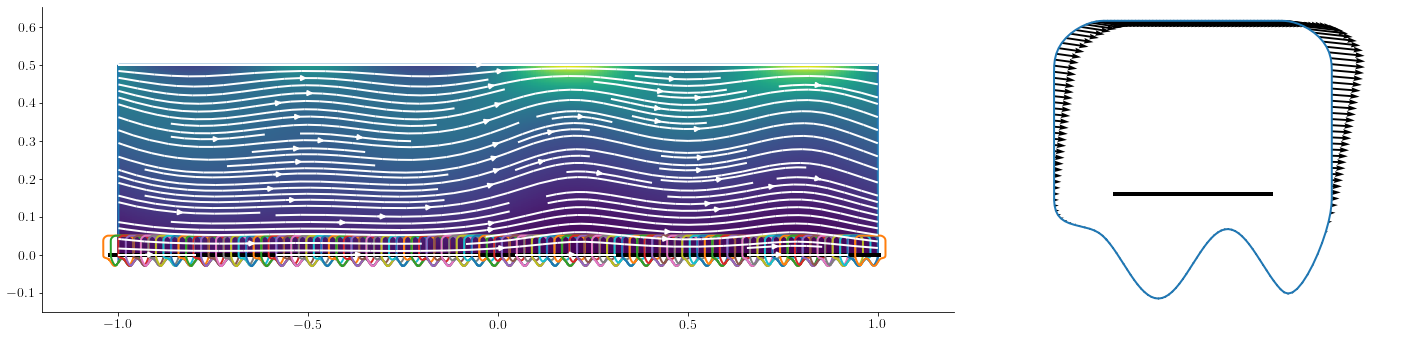

In [8]:
from util.basis_scaled import ScaleShiftedBasis
plt.figure(figsize=(20,5))

plt.subplot2grid((1, 3), (0, 0), 1, 2)
plt.axis("equal")
hmm_prob.plot(plt.gca())
macro_sol.u.plot(plt.gca())
macro_sol.plot_stream(plt.gca(), color="white")
w = dom[0][1] - dom[0][0]
plt.xlim([dom[0][0]-0.1*w, dom[0][1]+0.1*w])
plt.ylim([dom[1][0]-0.1*w, dom[1][1]+0.1*w])
remove_top_right_axes(plt.gca())

plt.subplot2grid((1, 3), (0, 2), 1, 1)
micros[0].plot(plt.gca())
micros[0].geom.plot_field_on_boundary(plt.gca(), micros[0].condition)
plt.axis("equal")
remove_axes(plt.gca())

In [9]:
Nx, Ny = 100, 100
xhd = np.linspace(dom[0][0],dom[0][1], Nx)
yhd = np.linspace(dom[1][0]-0.1,dom[1][1], Ny)
Xhd, Yhd = np.meshgrid(xhd, yhd)

full_micro_sols = []
for it, m in enumerate(micros):
    prob = StokesDirichletProblem(m.geom, m.condition)
    print(f"solving {it}/{len(micros)}", end="\r")
    prob.solve(verbose=False)
    full_micro_sols.append(prob)

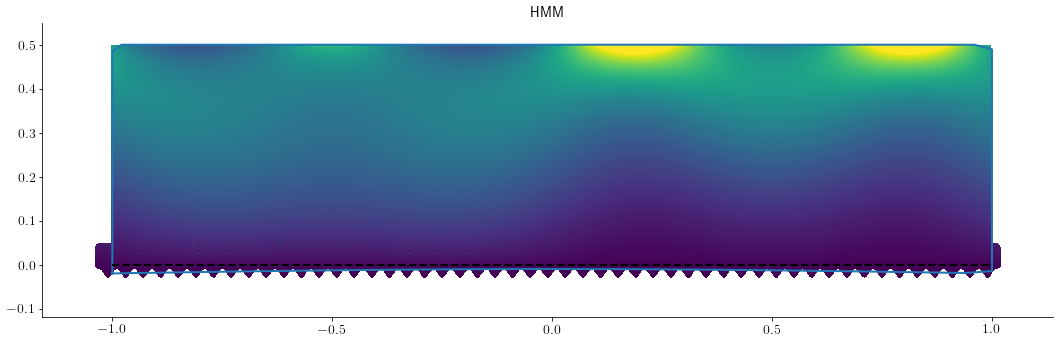

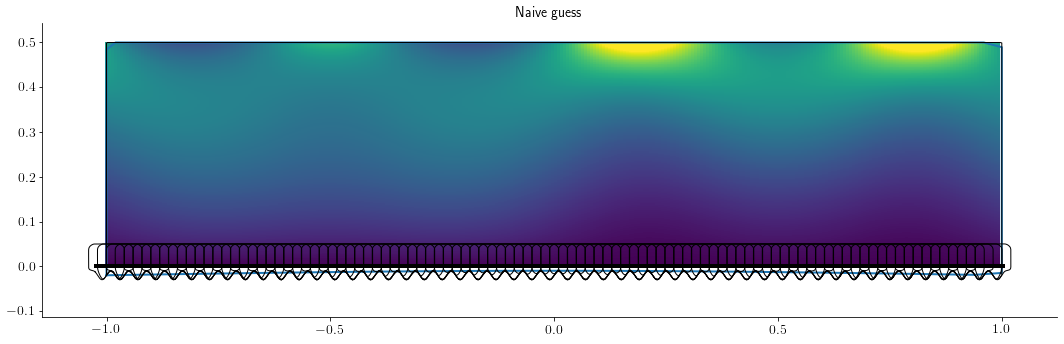

In [10]:


vmax, vmin = 5., 0.

plt.figure(figsize=(15,5))
plt.title("HMM")
macro_sol.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
for m, s in zip(micros, full_micro_sols):
    m.geom.plot_field(plt.gca(), lambda z: np.real(s.evaluate(z)), apply_mask=True, vmin=vmin, vmax=vmax)
#hmm_prob.plot(plt.gca(), color='black', linewidth=1)



plt.figure(figsize=(15,5))
plt.title("Naive guess")
macro_guess.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
hmm_prob.plot(plt.gca(), color='black', linewidth=1)



Verifying derivatives